<img src="../_static/Gamma_Facet_Logo_RGB_LB.svg" width="500" style="padding-bottom: 70px; padding-top: 70px; margin: auto; display: block">

# Regression with FACET: Predictive Maintenance

***

FACET is composed of the following key components:

- **Model Inspection**

    FACET introduces a new algorithm to quantify dependencies and interactions between features in ML models. This new tool for human-explainable AI adds a new, global perspective to the observation-level explanations provided by the popular [SHAP](https://shap.readthedocs.io/en/latest/) approach. To learn more about FACET's model inspection capabilities, see the getting started example below.


- **Model Simulation**

    FACET's model simulation algorithms use ML models for *virtual experiments* to help identify scenarios that optimise predicted  outcomes. To quantify the uncertainty in simulations, FACET utilises a range of bootstrapping algorithms including stationary and stratified bootstraps. For an example of FACET’s bootstrap simulations, see the getting started example below.    
    
    
- **Enhanced Machine Learning Workflow**  

    FACET offers an efficient and transparent machine learning workflow, enhancing [scikit-learn]( https://scikit-learn.org/stable/index.html)'s tried and tested pipelining paradigm with new capabilities for model selection, inspection, and simulation. FACET also introduces [sklearndf](https://github.com/BCG-Gamma/sklearndf), an augmented version of *scikit-learn* with enhanced support for *pandas* dataframes that ensures end-to-end traceability of features.       

***

**Context**

The data are from simulated experiments of a naval vessel (Frigate) Gas Turbine (GT) propulsion plant. The simulator considers the performance decay over time of the GT components such as GT compressor and turbines. One observation in this dataset represents the current decay states of the compressor and the gas turbine along with several sensor readings of the vessel at that point in time. The decay state is a performance metric [0, 1] where 1 means delivering 100% of nominal performance. We want to determine the machine settings which maximize the gas turbine decay state coefficient.

Utilizing FACET, we will: 

1. Predict the decay state of the gas turbine as accurately as possible
2. Understand which parameters drive the decay state of the turbine
3. Analyse how these drivers interact with each other and the target

While we can solve questions 1 and parts of question 2 with commonly used machine learning packages, FACET will enable us to make better inferences about the way some of the features share or complement information and help us to figure out the optimal settings of the vessel to minimize the equipment degradation at a variety of ship speeds.

***

**Tutorial outline**

1. [Required imports](#Required-imports)
2. [Preprocessing and initial feature selection](#Preprocessing-and-initial-feature-selection)
3. [Selecting a learner using FACET ranker](#Selecting-a-learner-using-FACET-ranker)
4. [Using FACET for advanced model inspection](#Using-FACET-for-advanced-model-inspection)
5. [FACET univariate simulator: the impact of compressor outlet air temp](#FACET-univariate-simulator:-the-impact-of-compressor-outlet-air-temp)
6. [Summary](#Summary)
7. [Appendix](#Appendix)

In [2]:
# this cell's metadata contains
# "nbsphinx": "hidden" so it is hidden by nbsphinx


def _ignore_warnings():
    # ignore irrelevant warnings that would affect the output of this tutorial notebook

    # ignore a useless LGBM warning
    import warnings

    warnings.filterwarnings("ignore", category=UserWarning, message=r".*Xcode_8\.3\.3")


_ignore_warnings()

del _ignore_warnings


import matplotlib.pyplot as plt


def _configure_matplotlib():
    # set global options for matplotlib

    import matplotlib

    matplotlib.rcParams["figure.figsize"] = (16.0, 8.0)
    matplotlib.rcParams["figure.dpi"] = 72


_configure_matplotlib()

del _configure_matplotlib

# Required imports

In order to run this notebook, we will import not only the FACET package, but also other packages useful to solve this task. Overall, we can break down the imports into three categories: 

1. Common packages (pandas, matplotlib, etc.)
2. Required FACET classes (inspection, selection, validation, simulation, etc.)
3. Other BCG GAMMA packages which simplify pipelining (sklearndf, see on [GitHub](https://github.com/BCG-Gamma/sklearndf/)) and support visualization (pytools, see on [GitHub](https://github.com/BCG-Gamma/pytools)) when using FACET

**Common package imports**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
from sklearn.model_selection import RepeatedKFold

**FACET imports**

In [4]:
from facet.data import Sample
from facet.crossfit import LearnerCrossfit
from facet.inspection import LearnerInspector
from facet.selection import LearnerRanker, LearnerGrid
from facet.validation import BootstrapCV
from facet.simulation.partition import ContinuousRangePartitioner
from facet.simulation import UnivariateUpliftSimulator
from facet.simulation.viz import SimulationDrawer

**sklearndf imports**

Instead of using the "regular" scikit-learn package, we are going to use sklearndf (see on [GitHub](https://github.com/BCG-Gamma/sklearndf/)). sklearndf is an open source library designed to address a common issue with scikit-learn: the outputs of transformers are numpy arrays, even when the input is a data frame. However, to inspect a model it is essential to keep track of the feature names. sklearndf retains all the functionality available through scikit-learn plus the feature traceability and usability associated with Pandas data frames. Additionally, the names of all your favourite scikit-learn functions are the same except for `DF` on the end. For example, the standard scikit-learn import:

`from sklearn.pipeline import Pipeline`

becomes:

`from sklearndf.pipeline import PipelineDF`  

In [5]:
from sklearndf.pipeline import PipelineDF, RegressorPipelineDF
from sklearndf.regression import RandomForestRegressorDF
from sklearndf.regression.extra import LGBMRegressorDF
from sklearndf.transformation.extra import BorutaDF
from sklearndf.transformation import SimpleImputerDF

**pytools imports**

pytools (see on [GitHub](https://github.com/BCG-Gamma/pytools)) is an open source library containing general machine learning and visualization utilities, some of which are useful for visualising the advanced model inspection capabilities of FACET.

In [6]:
from pytools.viz.dendrogram import DendrogramDrawer, DendrogramReportStyle
from pytools.viz.distribution import ECDFDrawer
from pytools.viz.matrix import MatrixDrawer

# Preprocessing and initial feature selection

First, we need to load our turbine decay data and create a simple preprocessing pipeline. For those interested initial EDA can be found in the Appendix [Exploratory Data Analysis](#Exploratory-Data-Analysis)

In [7]:
# load the prepared data frame
decay_df = pd.read_csv(
    "sphinx/source/tutorial/gas_turbine_data.txt", delim_whitespace=True
)

# assign human-readable labels
decay_df.columns = [
    "Lever Position",
    "Ship Speed",
    "Turbine Shaft Torque (kN m)",
    "Turbine Rate of Revolutions (rpm)",
    "Generator Rate of Revolutions (rpm)",
    "Starboard Propeller Torque (kN)",
    "Port Propeller Torque (kN)",
    "HP Turbine exit temp (C)",
    "GT Compressor inlet air temp (C)",
    "GT Compressor outlet air temp (C)",
    "Turbine exit pressure (bar)",
    "Compressor inlet air pressure (bar)",
    "Compressor outlet air pressure (bar)",
    "Turbine exhaust gas pressure (bar)",
    "Turbine injection control",
    "Fuel flow",
    "GT Compressor decay state coeff",
    "GT Turbine decay state coeff",
]

# need to drop the other target
decay_df.drop("GT Compressor decay state coeff", inplace=True, axis=1)

# to ensure quick running we will use a random sample of 2500 observations
decay_df = decay_df.sample(n=2500, random_state=42)

# have a look
decay_df.head()

,Lever Position,Ship Speed,Turbine Shaft Torque (kN m),Turbine Rate of Revolutions (rpm),Generator Rate of Revolutions (rpm),Starboard Propeller Torque (kN),Port Propeller Torque (kN),HP Turbine exit temp (C),GT Compressor inlet air temp (C),GT Compressor outlet air temp (C),Turbine exit pressure (bar),Compressor inlet air pressure (bar),Compressor outlet air pressure (bar),Turbine exhaust gas pressure (bar),Turbine injection control,Fuel flow,GT Turbine decay state coeff
10172,4.161,12.0,14718.310,1547.449,7719.516,113.742,113.742,631.252,288.0,602.602,1.664,0.998,8.939,1.023,16.815,0.333,0.987
10322,1.138,3.0,3348.329,1356.770,6601.505,7.894,7.894,547.508,288.0,557.501,1.213,0.998,6.598,1.019,14.993,0.192,0.978
9195,8.206,24.0,50992.407,3087.412,9298.581,438.063,438.063,918.698,288.0,728.328,3.599,0.998,18.620,1.042,60.231,1.192,0.982
357,8.206,24.0,50997.290,3087.621,9322.654,438.113,438.113,938.022,288.0,739.339,3.565,0.998,18.359,1.041,61.146,1.211,0.988
4352,7.148,21.0,38986.686,2678.079,9131.082,332.171,332.171,827.022,288.0,691.694,2.967,0.998,15.482,1.035,44.017,0.872,0.990


For easier data management we will create a sample object using FACET's `Sample` class, which allows us to: 

- Quickly access the target vs. features
- Pass our data into sklearndf pipelines
- Pass information to other FACET functions

In [8]:
decay_obs = Sample(observations=decay_df, target_name="GT Turbine decay state coeff")

Next, we should create a minimum preprocessing pipeline. However, based on our EDA ([Exploratory Data Analysis](#Exploratory-Data-Analysis-(EDA)) ) we have no missing values or a need to manage categorical variables etc. However, while it is not needed we will create a simple imputation preprocessing pipeline using sklearndf's `SimpleImputerDF` to demonstrate how such a pipeline is created and included in subsequent analytic steps.

In [9]:
feature_preprocessing = PipelineDF(steps=[("impute", SimpleImputerDF())])

Next, we perform some initial feature selection using Boruta, a recent approach shown to have quite good performance. The Boruta algorithm removes features that are no more predictive than random noise. If you are interested further, please see this  [article](https://www.jstatsoft.org/article/view/v036i11).

The `BorutaDF` transformer in sklearndf package provides easy access to this powerful method. The approach relies on a tree-based learner, usually a random forest. For settings, a `max_depth` of between 3 and 7 is typically recommended, and here we rely on the default setting of 5. However, as this depends on the number of features and the complexity of interactions one could also explore the sensitivity of feature selection to this parameter. The number of trees is automatically managed by the Boruta feature selector argument `n_estimators="auto"`.

We also use parallelization for the random forest using `n_jobs` to accelerate the Boruta iterations.

In [10]:
# create the Boruta object
boruta_feat_select = BorutaDF(
    estimator=RandomForestRegressorDF(max_depth=5, random_state=42, n_jobs=-3),
    n_estimators="auto",
    max_iter=50,
    random_state=42,
    verbose=False,
)

# combine Boruta with the preprocessing pipeline
selection_pipeline = PipelineDF(
    steps=[
        ("preprocessing", feature_preprocessing),
        ("feature selection", boruta_feat_select),
    ]
)

Since [sklearndf](https://github.com/BCG-Gamma/sklearndf) closely follows the `scikit-learn` syntax, we can fit this pipeline on the `sample.features` and `sample.target` properties.

In [11]:
# fit pipeline and print selected features
selection_pipeline.fit(X=decay_obs.features, y=decay_obs.target)
print(f"Selected features: {selection_pipeline.feature_names_original_.unique()}")

Selected features: ['Turbine Shaft Torque (kN m)' 'Turbine Rate of Revolutions (rpm)'
 'Generator Rate of Revolutions (rpm)' 'HP Turbine exit temp (C)'
 'GT Compressor outlet air temp (C)' 'Turbine exit pressure (bar)'
 'Compressor outlet air pressure (bar)'
 'Turbine exhaust gas pressure (bar)' 'Turbine injection control'
 'Fuel flow']


Boruta selected 10 features which we will now keep in our FACET sample object. Note that this feature selection process could be included in a general preprocessing pipeline, however due to the computation involved, we have utilized Boruta here as an initial one-off processing step to narrow down the features for our classifier development.

In [12]:
# update FACET sample object to only those features Boruta identified as useful
decay_obs_initial_features = decay_obs.keep(
    feature_names=selection_pipeline.feature_names_original_.unique()
)

# Selecting a learner using FACET ranker

FACET implements several additional useful wrappers which further simplify comparing and tuning a larger number of models and configurations: 

- `LearnerGrid`: allows you to pass a learner pipeline (i.e., regressor + any preprocessing) and a set of hyperparameters
- `LearnerRanker`: multiple LearnerGrids can be passed into this class as a list - this allows tuning hyperparameters both across different types of learners in a single step and ranks the resulting models accordingly

The following learners and hyperparameter ranges will be assessed using 10 repeated 5-fold cross-validation:


1. **Random forest**: with hyperparameters
    - min_samples_leaf: [8, 16]
    - n_estimators: [20, 50, 100]  
  
  
2. **Light gradient boosting**: with hyperparameters
    - min_data_in_leaf: [8, 16]
    - subsample: [0.8, 1]
    - boosting_type: ["gbdt"]
    
Note if you want to see a list of hyperparameters you can use `regressor_name().get_params().keys()` where `regressor_name` could be for example `RandomForestRegressorDF` and if you want to see the default values, just use `regressor_name().get_params()`.

Finally, for this exercise we will use the default performance metric for scoring and ranking our regressors, which is explained variance. Note that ranking uses the average performance minus two times the standard deviation, so that we consider both the average performance and variability when selecting a regressor.

First, we specify the classifiers we want to train using `RegressorPipelineDF` from sklearndf. Note here we could also include any feature preprocessing steps by using the `preprocessing` argument.

In [13]:
rforest_regressor = RegressorPipelineDF(
    regressor=RandomForestRegressorDF(random_state=42),
)

lgbm_regressor = RegressorPipelineDF(
    regressor=LGBMRegressorDF(random_state=42),
)

Then we create a list of learner grids where each learner grid is created using `LearnerGrid` and allows us to associate a `RegressorPipelineDF` with a specified set of hyperparameter via the `learner_parameters` argument. Note this structure allows us to easily include additional regressors and hyperparameters.

In [14]:
regressor_grid = [
    LearnerGrid(
        pipeline=rforest_regressor,
        learner_parameters={"min_samples_leaf": [8, 16], "n_estimators": [20, 50, 100]},
    ),
    LearnerGrid(
        pipeline=lgbm_regressor,
        learner_parameters={
            "min_data_in_leaf": [8, 16],
            "subsample": [0.8, 1],
            "boosting_type": ["gbdt"],
        },
    ),
]

We now fit the grid defined above using the `LeanerRanker`, which will run a gridsearch (or random search if defined) using 10 repeated 5-fold cross-validation on our selected set of features from Boruta.

In [15]:
regressor_ranker = LearnerRanker(
    grids=regressor_grid,
    cv=RepeatedKFold(n_splits=5, n_repeats=10, random_state=42),
    n_jobs=-3,
    verbose=False,
    scoring="explained_variance",
).fit(sample=decay_obs_initial_features)

[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8


We can see how each model scored using the `summary_report()` method of the `LearnerRanker`.

In [16]:
# let's look at performance for the top 5 ranked regressors
regressor_ranker.summary_report()

ranking_score explained_variance                          regressor  \
                                 mean       std                     type   
rank                                                                       
0         0.941008           0.957769  0.008381          LGBMRegressorDF   
1         0.941008           0.957769  0.008381          LGBMRegressorDF   
2         0.935509           0.952824  0.008658          LGBMRegressorDF   
3         0.935509           0.952824  0.008658          LGBMRegressorDF   
4         0.876689           0.903802  0.013557  RandomForestRegressorDF   
5         0.876476           0.903111  0.013318  RandomForestRegressorDF   
6         0.873774           0.900475  0.013351  RandomForestRegressorDF   
7         0.817858           0.849153  0.015647  RandomForestRegressorDF   
8         0.817152           0.848478  0.015663  RandomForestRegressorDF   
9         0.814505           0.846019  0.015757  RandomForestRegressorDF   

                                                                             
     n_estimators min_samples_leaf subsample boosting_type min_data_in_leaf  
rank                                                                         
0             NaN              NaN       0.8          gbdt              8.0  
1             NaN              NaN       1.0          gbdt              8.0  
2             NaN              NaN       0.8          gbdt             16.0  
3             NaN              NaN       1.0          gbdt             16.0  
4           100.0              8.0       NaN           NaN              NaN  
5            50.0              8.0       NaN           NaN              NaN  
6            20.0              8.0       NaN           NaN              NaN  
7           100.0             16.0       NaN           NaN              NaN  
8            50.0             16.0       NaN           NaN              NaN  
9            20.0             16.0       NaN           NaN              NaN

We can see based on our learner ranker, we have selected a LGBM algorithm that achieved a mean explained variance of 0.96 with a SD of 0.01.

# Using FACET for advanced model inspection

The [SHAP approach](http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions) has become the standard method for model inspection. SHAP values are used to explain the additive contribution of each feature to the prediction for each observation (i.e., explain **individual** predictions).

The FACET `LearnerInspector` computes SHAP values for each crossfit (i.e., a CV fold or bootstrap resample) using the best model identified by the `LearnerRanker`. The FACET `LearnerInspector` then provides advanced model inspection through new SHAP-based summary metrics for understanding pairwise feature redundancy and synergy. Redundancy and synergy are calculated using a new algorithm to understand model predictions from a **global perspective** to complement local SHAP.

The definitions of synergy and redundancy are as follows:

- **Synergy**

  The degree to which the model combines information from one feature with 
  another to predict the target. For example, let's assume we are predicting 
  cardiovascular health using age and gender and the fitted model includes 
  a complex interaction between them. This means these two features are 
  synergistic for predicting cardiovascular health. Further, both features 
  are important to the model and removing either one would significantly 
  impact performance. Let's assume age is a more important feature than 
  gender and so age contributes more to the combined prediction than 
  gender. This asymmetric contribution means the synergy for (age, gender) 
  is less than the synergy for (gender, age). To think about it another 
  way, imagine the prediction is a coordinate you are trying to reach. 
  From your starting point, age gets you much closer to this point than 
  gender, however, you need both to get there. Synergy reflects the fact 
  that gender gets more help from age (higher synergy from the perspective 
  of gender) than age does from gender (lower synergy from the perspective of
  age) to reach the prediction. *This leads to an important point: synergy 
  is a naturally asymmetric property of the global information two interacting 
  features contribute to the model predictions.* Synergy is expressed as a 
  percentage ranging from 0% (full autonomy) to 100% (full synergy).


- **Redundancy**

  The degree to which a feature in a model duplicates the information of a 
  second feature to predict the target. For example, let's assume we had 
  house size and number of bedrooms for predicting house price. These 
  features capture similar information as the more bedrooms the larger 
  the house and likely a higher price on average. The redundancy for 
  (number of bedrooms, house size) will be greater than the redundancy 
  for (house size, number of bedrooms). This is because house size 
  "knows" more of what number of bedrooms does for predicting house price 
  than vice-versa. Hence, there is greater redundancy from the perspective 
  of number of bedrooms. Another way to think about it is removing house 
  size will be more detrimental to model performance than removing number 
  of bedrooms, as house size can better compensate for the absence of 
  number of bedrooms. This also implies that house size would be a more 
  important feature than number of bedrooms in the model. *The important 
  point here is that like synergy, redundancy is a naturally asymmetric 
  property of the global information feature pairs have for predicting 
  an outcome.* Redundancy is expressed as a percentage ranging from 0% 
  (full uniqueness) to 100% (full redundancy).


Note that cases can apply at the same time so a feature pair can use some information synergistically and some information redundantly.

The FACET `LearnerInspector` can calculate all of this with a single method call, but also offers methods to access the intermediate results of each step. A lightweight visualization framework is available to render the results in different styles.

SHAP values from the `LearnerInspector` can also be used with the SHAP package plotting functions for sample and observation level SHAP visualizations, such as SHAP distribution plots, dependency plots, force plots and waterfall plots.

In [17]:
# run inspector
regression_inspector = LearnerInspector()
regression_inspector.fit(
    n_jobs=-3, verbose=False, crossfit=regressor_ranker.best_model_crossfit_
)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [38]:
# quick look at feature importance
regression_inspector.feature_importance().sort_values(ascending=False)

feature
Compressor outlet air pressure (bar)    0.256469
Generator Rate of Revolutions (rpm)     0.155129
Turbine Shaft Torque (kN m)             0.132486
Turbine Rate of Revolutions (rpm)       0.129988
Turbine exhaust gas pressure (bar)      0.107262
GT Compressor outlet air temp (C)       0.071312
Turbine injection control               0.061194
Fuel flow                               0.044075
Turbine exit pressure (bar)             0.025341
HP Turbine exit temp (C)                0.016744
Name: GT Turbine decay state coeff, dtype: float64

## Synergy

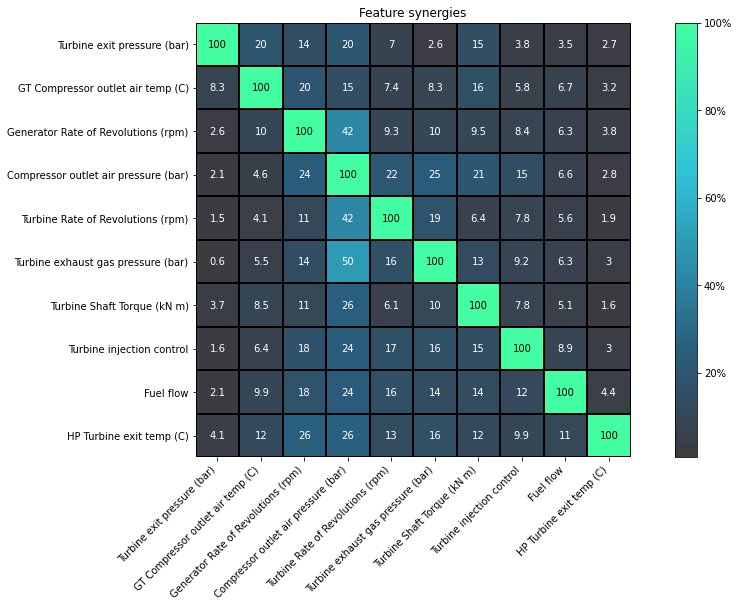

In [18]:
# synergy heatmaps
synergy_matrix = regression_inspector.feature_synergy_matrix()
MatrixDrawer(style="matplot%").draw(synergy_matrix, title="Feature synergies")

To interpret the synergy matrix, the first feature in a pair is the row ("perspective from"), and the second feature the column. For example, let's take the highest synergy value of 50% for the feature pair (`Turbine exhaust gas pressure (bar)`, `Compressor outlet air pressure (bar)`). This means from the perspective of `Turbine exhaust gas pressure (bar)` we find that 50% of the information is combined with `Compressor outlet air pressure (bar)` to predict the decay state of the gas turbine.

Further if we look at the column for `Compressor outlet air pressure (bar)`, we see from the perspective of other features in the model the synergy with `Compressor outlet air pressure (bar)` ranges from 15% to 50%. This indicates that `Compressor outlet air pressure (bar)` is a strong independent feature in the model (it actually has the highest feature importance in the model) and that contributions of other features to predicting the decay state of the gas turbine are partly enabled by `Compressor outlet air pressure (bar)`.

## Redundancy

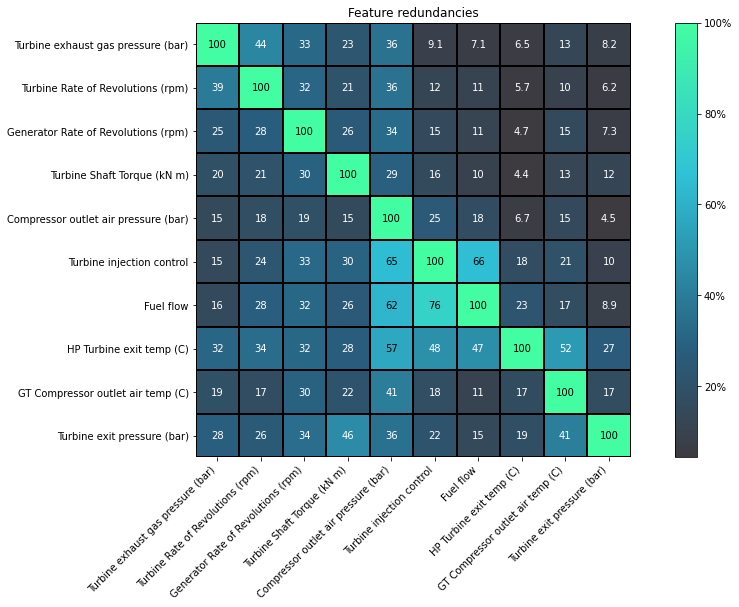

In [19]:
# redundancy heatmap
redundancy_matrix = regression_inspector.feature_redundancy_matrix()
MatrixDrawer(style="matplot%").draw(redundancy_matrix, title="Feature redundancies")

As with synergy, the matrix row is the "perspective from" feature in the row-column feature pair. Let's continue with the most important feature in the model `Compressor outlet air pressure (bar)`. If we look across the row for `Compressor outlet air pressure (bar)` which is redundancy from the perspective of `Compressor outlet air pressure (bar)` we can see that it has little redundancy with the other models features (4.5% to 25%). If look along the column for `Compressor outlet air pressure (bar)` we can see from the perspective of the other model features there is a moderate degree of redundancy with `Compressor outlet air pressure (bar)`, ranging from 29% to 65%.

We can also see the highest redundancy (76%) is for (`Fuel flow`, `Turbine injection control`). This would mean that from the perspective of `Fuel flow` 76% of the information is duplicated with `Turbine injection control` to predict the decay state of the gas turbine. Intuitively this makes sense as fuel flow is a consequence of the turbine injection control.

## Feature clustering

As detailed above redundancy and synergy for a feature pair is from the "perspective" of one of the features in the pair, and so yields two distinct values. However, a symmetric version can also be computed that provides not only a simplified perspective but allows the use of (1 - metric) as a feature distance. With this distance hierarchical, single linkage clustering is applied to create a dendrogram visualization. This helps to identify groups of low distance, features which activate "in tandem" to predict the outcome. Such information can then be used to either reduce clusters of highly redundant features to a subset or highlight clusters of highly synergistic features that should always be considered together.

For this example, let's apply clustering to redundancy to see how the apparent grouping observed in the heatmap appears in the dendrogram. Ideally, we want to see features only start to cluster as close to the right-hand side of the dendrogram as possible. This implies all features in the model are contributing uniquely to our predictions.

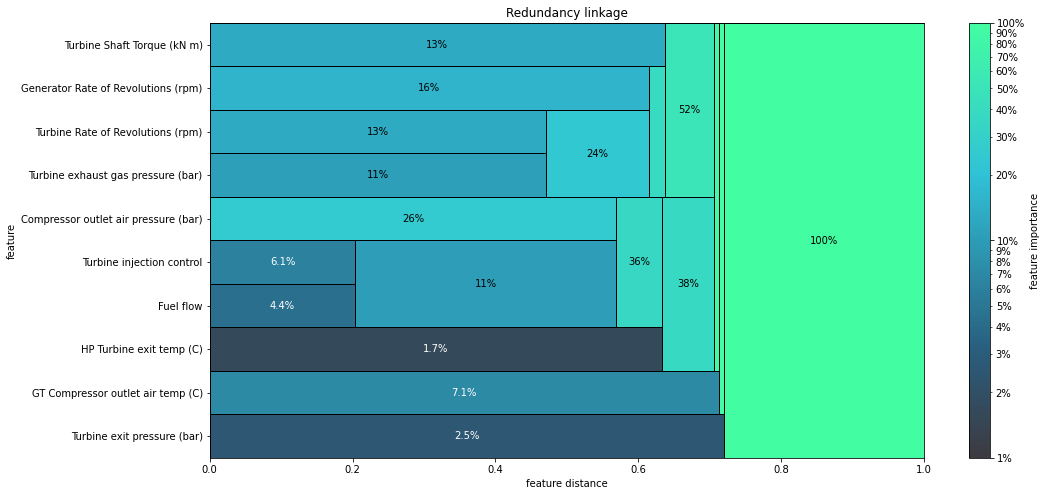

In [20]:
# redundancy dendrogram
redundancy_linkage = regression_inspector.feature_redundancy_linkage()
DendrogramDrawer().draw(title="Redundancy linkage", data=redundancy_linkage)

For convenience when working in a non-notebook environment, all of the `Drawer`s provided by the [pytools](https://github.com/BCG-Gamma/pytools) package also support a `style='text'` flag.  

In [21]:
DendrogramDrawer(style="text").draw(title="Redundancy linkage", data=redundancy_linkage)

****************************** Redundancy linkage ******************************
                                                                                
Turbine Shaft T 13% --------------------------------------\                     
Generator Rate  16% ------------------------------------\ |___                  
Turbine Rate of 13% ----------------------------\_______/-/   \                 
Turbine exhaust 11% ----------------------------/             |                 
Compressor outl 26% ----------------------------------\       \\_______________ 
Turbine injecti  6% ------------\_____________________/--\____||                
Fuel flow        4% ------------/                        |    ||                
HP Turbine exit  2% -------------------------------------/    ||                
GT Compressor o  7% ------------------------------------------/|                
Turbine exit pr  3% -------------------------------------------/                


**What might we infer from synergy, redundancy and redundancy feature clustering?**

- We can see in the synergy matrix that many features are synergistic with `Compressor outlet air pressure (bar)`. This means `Compressor outlet air pressure (bar)` enables many other features in the model to contribute to predicting the the decay state of the gas turbine. 

- The redundancy matrix and dendrogram revealed two clusters of feature pairs that are redundant: (`Fuel flow`, `Turbine injection control`) and (`Turbine Rate of Revolutions (rpm)`, `Turbine exhaust gas pressure (bar)`). In the case of the second feature pair, again it seems sensible as the higher the pressure the higher the rate of revolutions.

**What action(s) might we take?**

We can remove the redundant features from the sample and create a revised sample on which we re-train the pipeline. This will result in a simpler model with improved independence between features.

In [22]:
redundant_features = ["Fuel flow", "Turbine exhaust gas pressure (bar)"]
decay_obs_no_redundant = decay_obs_initial_features.drop(feature_names=redundant_features)

In [23]:
# run the training pipeline again
regressor_ranker = LearnerRanker(
    grids=regressor_grid,
    cv=RepeatedKFold(n_splits=5, n_repeats=10, random_state=42),
    n_jobs=-3,
    verbose=False,
).fit(sample=decay_obs_no_redundant)

We can also check the best ranked model after removing redundant features.

In [24]:
regressor_ranker.best_model_

RegressorPipelineDF(regressor=LGBMRegressorDF(min_data_in_leaf=8,
                                              random_state=42, subsample=0.8))

# FACET univariate simulator: the impact of compressor outlet air temp

Another advantage of FACET is the ability to quickly instigate and run univariate simulations. Simulation enables us to gain insight into what value(s) of a feature of interest might minimize performance decay. Further, because FACET can use bootstrap cross validation, we can create a crossfit from our previous `LearnerRanker` best model to perform the simulation and to also quantify the uncertainty by using bootstrap confidence intervals.

Suggesting that `GT Compressor outlet air temp (C)` is a parameter that operators mainly use, we would like to estimate how temperature values might impact performance decay.

As the basis for the simulation, we divide the feature into relevant partitions: 

- We use FACET's `ContinuousRangePartitioner` to split the range of observed values of the outlet air temperature into intervals of equal size. Each partition is represented by the central value of that partition. 
- For each partition, the simulator creates an artificial copy of the original sample assuming the variable to be simulated has the same value across all observations - which is the value representing the partition. Using the best `LearnerCrossfit` acquired from the ranker, the simulator now re-predicts all targets using the models trained for all folds and determines the average uplift of the target variable resulting from this.
- The FACET `SimulationDrawer` allows us to visualise the result; both in a matplotlib and a plain-text style

Finally, because FACET can use bootstrap cross validation, we can create a crossfit from our previous `LearnerRanker` best model to perform the simulation so we can quantify the uncertainty by using bootstrap confidence intervals.

In [25]:
boot_crossfit = LearnerCrossfit(
    pipeline=regressor_ranker.best_model_,
    cv=BootstrapCV(n_splits=1000, random_state=42),
    n_jobs=-3,
    verbose=False,
).fit(sample=decay_obs_no_redundant)

In [26]:
# set-up and run a simulation
SIM_FEATURE = "GT Compressor outlet air temp (C)"
GTC_air_temp_simulator = UnivariateUpliftSimulator(crossfit=boot_crossfit, n_jobs=3)
GTC_air_temp_partitions = ContinuousRangePartitioner()
GTC_air_temp_simulation = GTC_air_temp_simulator.simulate_feature(
    feature_name=SIM_FEATURE, partitioner=GTC_air_temp_partitions
)

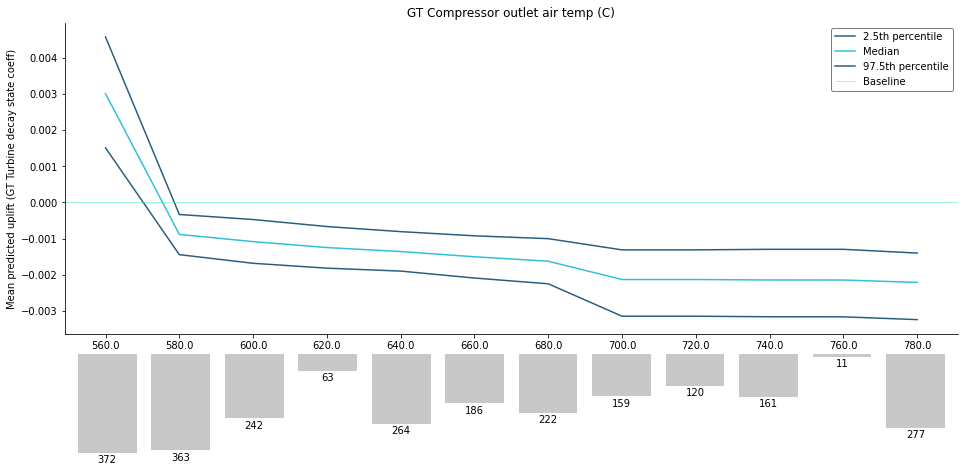

In [27]:
# visualize the results
SimulationDrawer().draw(data=GTC_air_temp_simulation, title=SIM_FEATURE)

In [28]:
# can also get a print out of simulation results
SimulationDrawer("text").draw(data=GTC_air_temp_simulation, title=SIM_FEATURE)

********************** GT Compressor outlet air temp (C) ***********************

Mean predicted uplift (GT Turbine decay state coeff):

Baseline = 0.0

Partition  2.5th percentile  Median     97.5th percentile
=========  ================  =========  =================
560                0.00151    0.003              0.00457 
580               -0.00144   -0.000883          -0.000332
600               -0.00168   -0.00108           -0.000471
620               -0.00181   -0.00124           -0.000665
640               -0.00189   -0.00135           -0.000805
660               -0.00209   -0.0015            -0.000921
680               -0.00225   -0.00162           -0.000999
700               -0.00314   -0.00213           -0.00131 
720               -0.00314   -0.00213           -0.00131 
740               -0.00315   -0.00214           -0.00129 
760               -0.00316   -0.00214           -0.00129 
780               -0.00323   -0.00221           -0.0014  

Observed frequencies:

Partition  

We can see from this that the turbine decay state coefficient is maximized when the outlet air temperature of the gas turbine is as small as possible. Note that this is only looking at the partitions of the historically observed range, as extrapolating these predictions into unobserved regions would risk creating infeasible scenarios. 

# Summary

With the capabilities offered by FACET we were able to:

1. Identify a learner using with good performance for predicting performance decay.
2. Utilize advanced the SHAP value capabilities (synergy and redundancy) to identify additional features that could be removed (i.e., fuel flow and turbine exhaust gas pressure) and whether any features had strong synergistic effects - which in this case was primarily between turbine exhaust gas pressure and turbine rate of revolutions.
3. Simulate the effect of changes in GT compressor outlet air temp on performance decay.

# Appendix

## Data source

**Dataset**

The dataset used in this example is available on [Kaggle](https://www.kaggle.com/elikplim/maintenance-of-naval-propulsion-plants-data-set) and contains data from experiments carried out by means of a numerical simulator of a naval vessel (Frigate) characterized by a **Gas Turbine propulsion plant**. In this release of the simulator it is also possible to consider the performance decay over time of the GT components such as GT compressor and turbines.

Each possible degradation state of the plant can be characterized by three parameters: 

- Ship speed (linear function of the lever position)
- Compressor degradation coefficient kMc
- Turbine degradation coefficient

The degradation coefficients typically vary between [1; 0.95] for compressor and [1; 0.975] for the gas turbine. 

**Features**

One observation in this dataset represents the current decay states of the compressor and the gas turbine along with several sensor readings of the shipping vessels at that point in time. 

Our target, the Gas Turbine decay  state is being modelled as a performance decay state metric which is measured as 1 to 0, 1 meaning delivering 100% of the nominal performance. Therefore, we want to determine the machine settings which **maximize the gas turbine decay state coefficient**. 


**Learning Problem**

For this learning problem, we have three key objectives: 

1. Predict the decay state of the gas turbine as accurately as possible
2. Understand which parameters drive the decay state of the turbine
3. Analyse how these drivers interact with each other and the target


While we can solve questions 1 and parts of question 2 with commonly used machine learning packages, FACET will enable us to make better inferences about the way some of the features share or complement information and help us to figure out the optimal settings of the vessel to minimize the equipment degradation at a variety of ship speeds.

Reference for the dataset used in this example is: A. Coraddu, L. Oneto, A. Ghio, S. Savio, D. Anguita, M. Figari, Machine Learning Approaches for Improving Condition? Based Maintenance of Naval Propulsion Plants, Journal of Engineering for the Maritime Environment, 2014, DOI: 10.1177/1475090214540874, (In Press)

## Exploratory Data Analysis (EDA)

In [29]:
decay_df = pd.read_csv(
    "sphinx/source/tutorial/gas_turbine_data.txt", delim_whitespace=True
)

decay_df.columns = [
    "Lever Position",
    "Ship Speed",
    "Turbine Shaft Torque (kN m)",
    "Turbine Rate of Revolutions (rpm)",
    "Generator Rate of Revolutions (rpm)",
    "Starboard Propeller Torque (kN)",
    "Port Propeller Torque (kN)",
    "HP Turbine exit temp (C)",
    "GT Compressor inlet air temp (C)",
    "GT Compressor outlet air temp (C)",
    "Turbine exit pressure (bar)",
    "Compressor inlet air pressure (bar)",
    "Compressor outlet air pressure (bar)",
    "Turbine exhaust gas pressure (bar)",
    "Turbine injection control",
    "Fuel flow",
    "GT Compressor decay state coeff",
    "GT Turbine decay state coeff",
]

TARGET = "GT Turbine decay state coeff"

In [30]:
# need to drop the other target
decay_df.drop("GT Compressor decay state coeff", inplace=True, axis=1)

In [31]:
# describe the data
decay_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Lever Position,11933.0,5.167004,2.626239e+00,1.138,3.144,5.140,7.148,9.300
Ship Speed,11933.0,15.001006,7.745837e+00,3.000,9.000,15.000,21.000,27.000
Turbine Shaft Torque (kN m),11933.0,27249.757760,2.214817e+04,253.547,8375.886,21630.666,39001.427,72784.872
Turbine Rate of Revolutions (rpm),11933.0,2136.355191,7.740828e+02,1307.675,1386.758,1924.326,2678.079,3560.741
Generator Rate of Revolutions (rpm),11933.0,8201.074989,1.091272e+03,6589.002,7058.402,8482.088,9132.610,9797.103
Starboard Propeller Torque (kN),11933.0,227.354184,2.004942e+02,5.304,60.317,175.268,332.365,645.249
Port Propeller Torque (kN),11933.0,227.354184,2.004942e+02,5.304,60.317,175.268,332.365,645.249
HP Turbine exit temp (C),11933.0,735.518197,1.736700e+02,442.364,589.875,706.048,834.091,1115.797
GT Compressor inlet air temp (C),11933.0,288.000000,0.000000e+00,288.000,288.000,288.000,288.000,288.000
GT Compressor outlet air temp (C),11933.0,646.223347,7.267365e+01,540.442,578.102,637.142,693.928,789.094


We can also quickly check for missing values, although we can see that there appears to be none.

In [32]:
# count missing by feature
decay_df.isna().sum(axis=0)

Lever Position                          0
Ship Speed                              0
Turbine Shaft Torque (kN m)             0
Turbine Rate of Revolutions (rpm)       0
Generator Rate of Revolutions (rpm)     0
Starboard Propeller Torque (kN)         0
Port Propeller Torque (kN)              0
HP Turbine exit temp (C)                0
GT Compressor inlet air temp (C)        0
GT Compressor outlet air temp (C)       0
Turbine exit pressure (bar)             0
Compressor inlet air pressure (bar)     0
Compressor outlet air pressure (bar)    0
Turbine exhaust gas pressure (bar)      0
Turbine injection control               0
Fuel flow                               0
GT Turbine decay state coeff            0
dtype: int64

We can use pytool's `ECDFDrawer()` to draw the cumulative distribution of the target. This shows us that the target is uniformly distributed in increments of 0.001 increments.

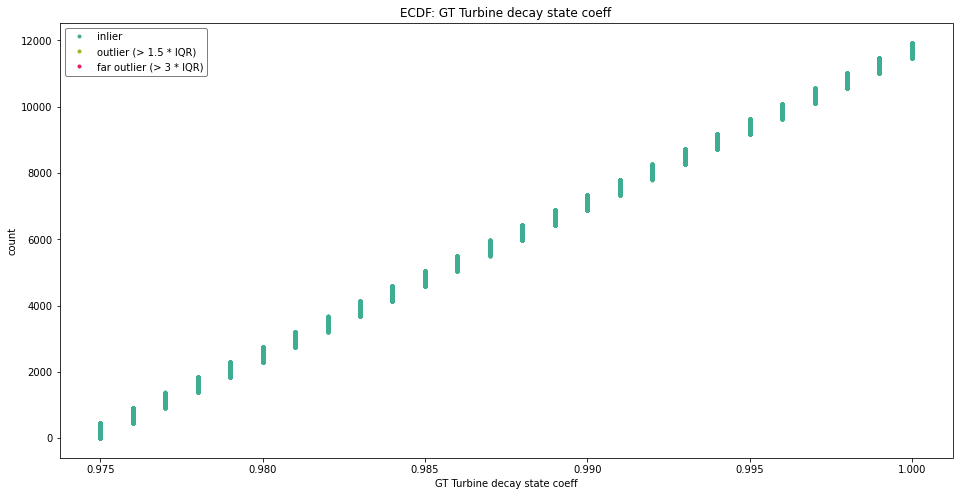

In [33]:
# look at the target distribution
decay_obs = Sample(observations=decay_df, target_name=TARGET)
ECDFDrawer().draw(data=decay_obs.target)

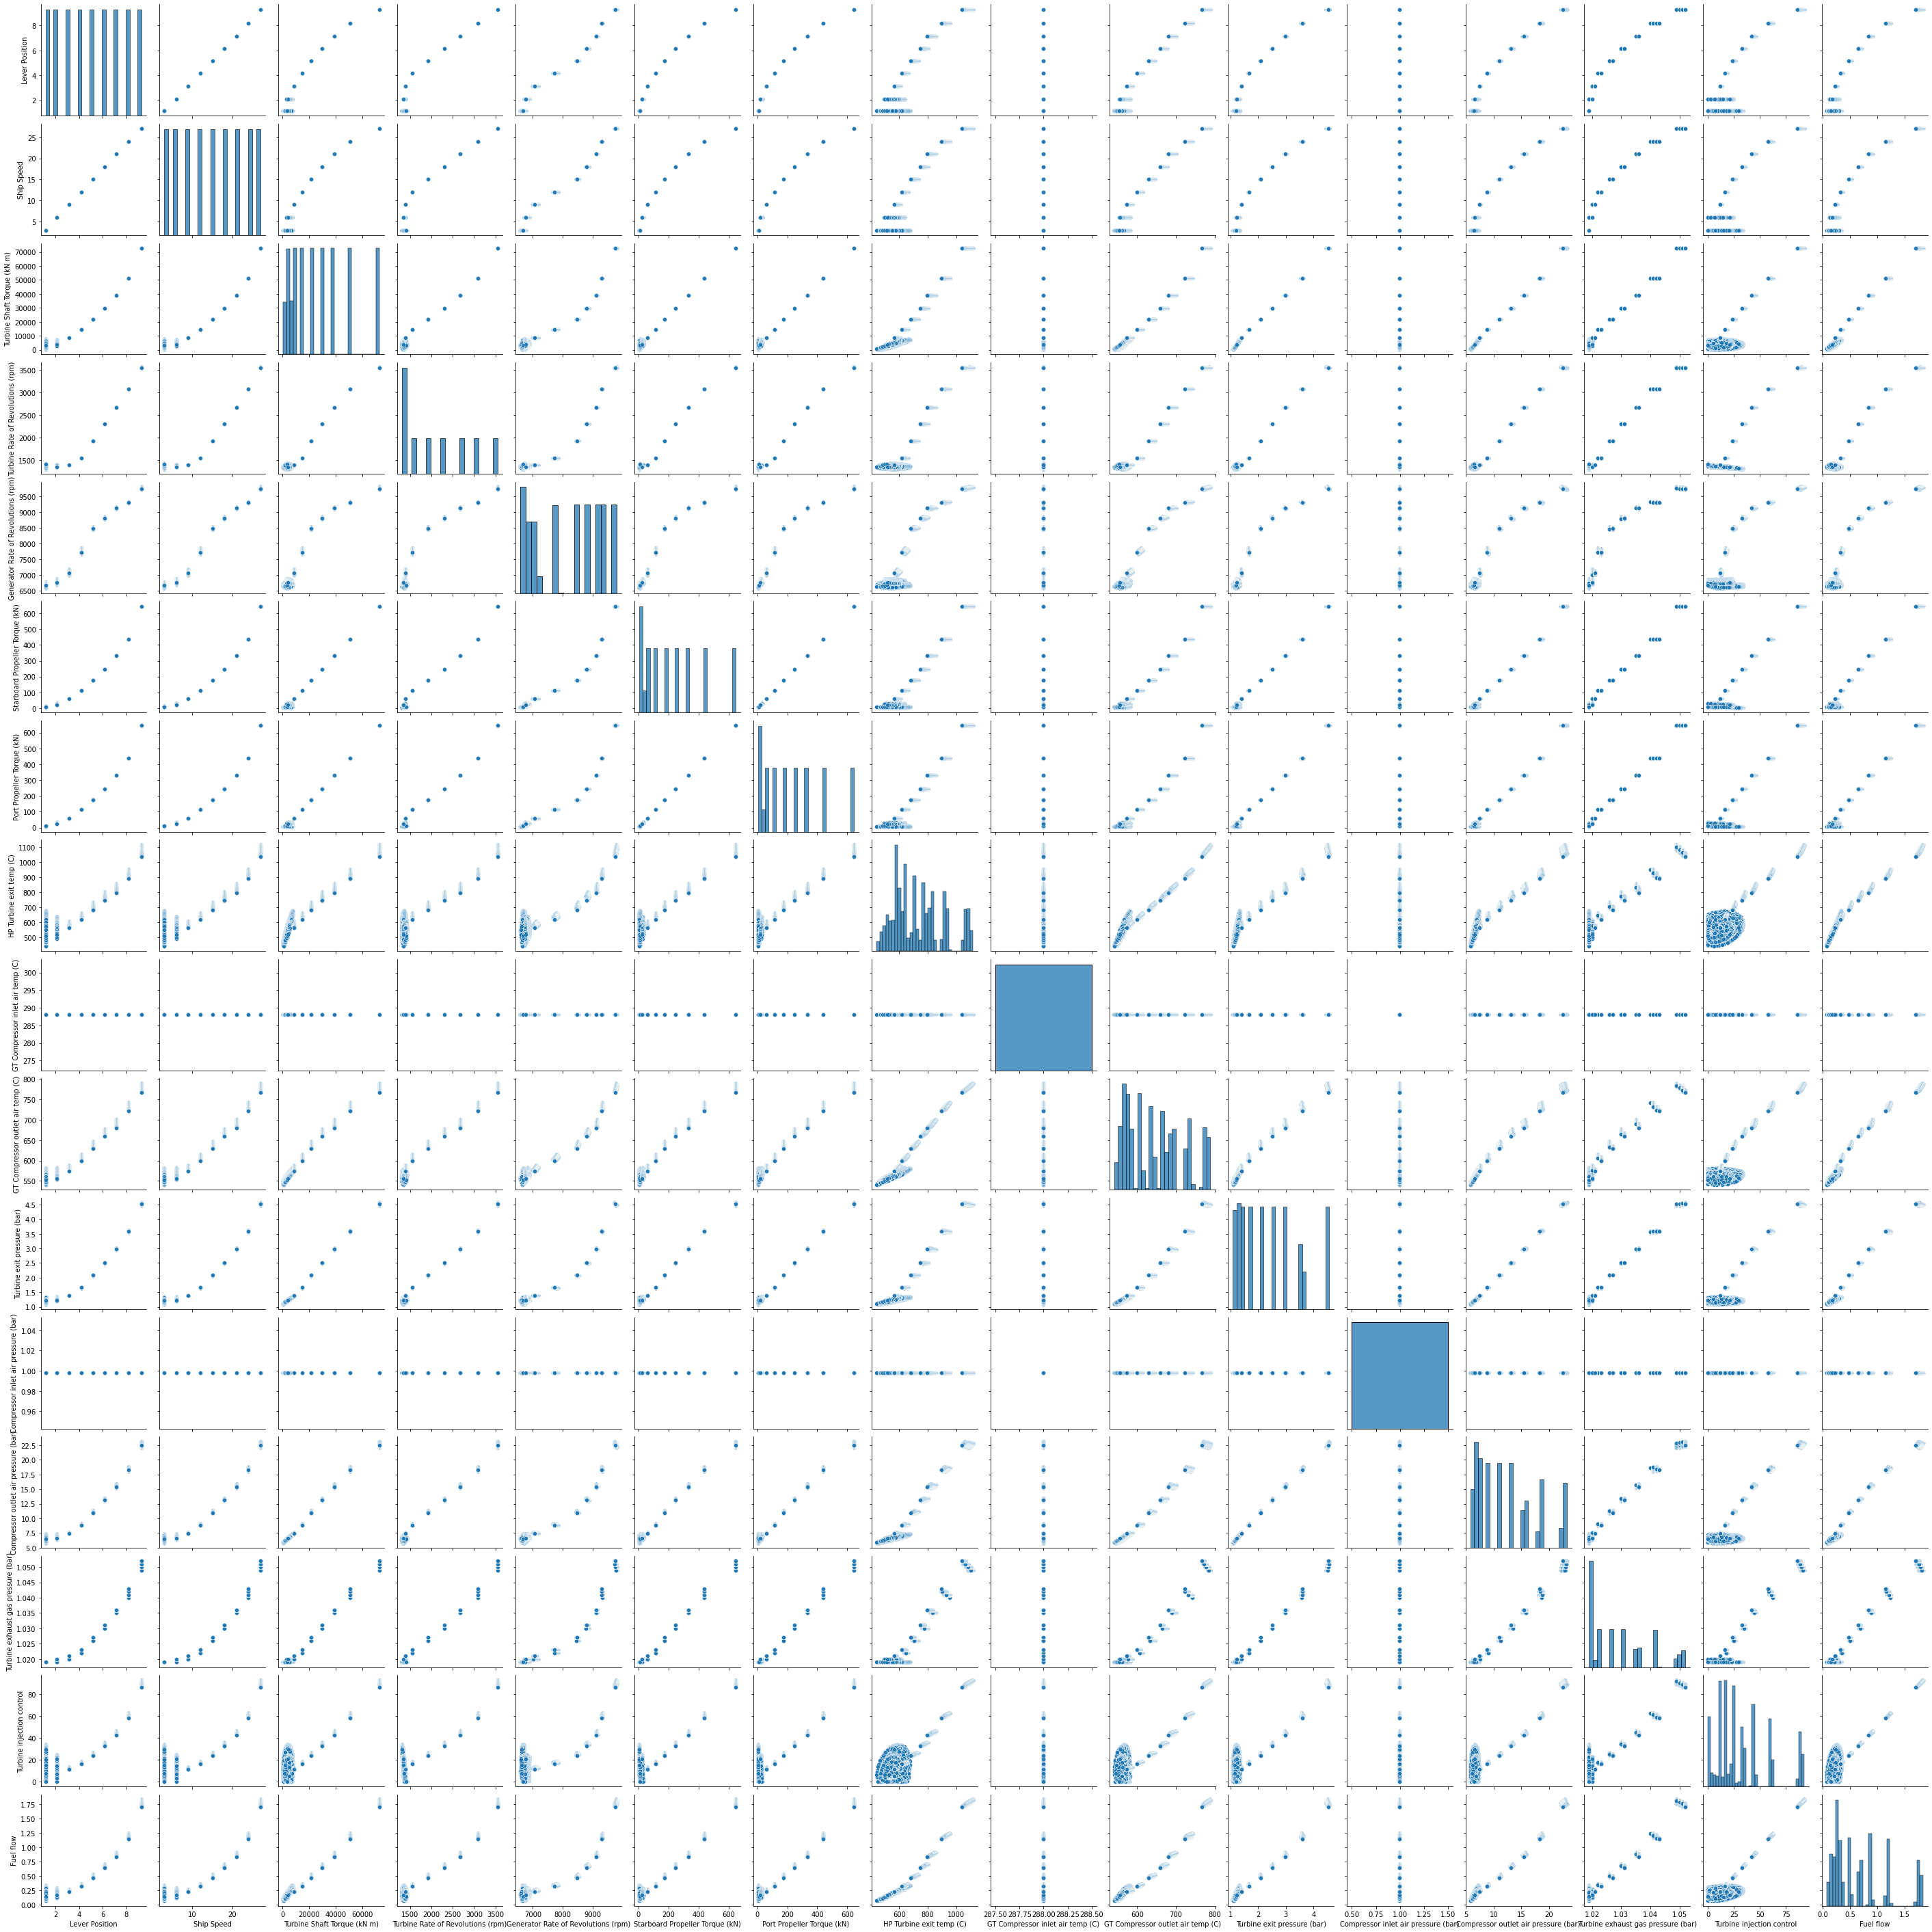

In [34]:
# look at feature distributions and correlations
sns.pairplot(decay_obs.features)

**Quick EDA summary:**

- We have no missing values in our data
- We are dealing with a linearly distributed target
- The features exhibit a mixture of linear and non-linear relationships amongst each other. This gives us reason to test several non-parametric models and compare their performance